# Set-Up

In [ ]:
!pip install sentence-transformers umap-learn hdbscan scikit-learn

In [ ]:
import json
import random
import time
from collections import Counter
from itertools import product

import hdbscan
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import torch
import umap.umap_ as umap
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
from tqdm import tqdm
from tqdm.auto import tqdm

from google.colab import drive

In [ ]:
FILE_PATH = "/content/drive/MyDrive/BT4012 Group 16!!/" # change the file path accordingly

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Obtain full_df to extract all available fraud cases
# Read from df with all the engineered features (before selection)
train_df = pd.read_csv(f"{FILE_PATH}clustering_train_df.csv")
test_df = pd.read_csv(f"{FILE_PATH}clustering_test_df.csv")

full_df = pd.concat([train_df, test_df], ignore_index=True)

# All fraud cases in the dataset
fraud_df = full_df[full_df['fraudulent'] == 1].copy()

print(fraud_df.shape)

(866, 338)


In [ ]:
fraud_df.head(5)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,...,requirements_all_caps_words_log,requirements_gunning_fog_log,requirements_POS_TOTAL_TOKENS_log,benefits_sentence_count_log,benefits_exclamation_count_log,benefits_question_count_log,benefits_all_caps_words_log,benefits_gunning_fog_log,benefits_POS_TOTAL_TOKENS_log,location_segment_count_log
26,17128,Customer Service Rep,"US, MO, Grandview",customer service,NaN,NaN,We are seeking a Customer Service Representati...,NaN,NaN,0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.386294
39,5751,"Agency Sales Managers $150-$175,000/yr","US, NY, Elmira",NaN,NaN,We have aggressive growth plans in place for t...,We provide No Credit Check Financing to custom...,Experience and Skills Required- Minimum of 3 ...,We Provide- Complete online training and offic...,0,...,0.0,3.245467,3.663562,0.000000,0.0,0.0,0.0,3.265014,3.784190,1.386294
54,5611,Optical Sales,"US, NY, Plainview",NaN,NaN,NaN,Optometric practice is seeking a full-time Opt...,Responsibilities include educating and assisti...,We offer a team-oriented work environment and ...,0,...,0.0,3.395999,3.610918,0.693147,0.0,0.0,0.0,3.182753,3.258097,1.386294
75,17519,Part Time Cash Jobs To Immediate Starts.,"US, CA, Los Angeles",NaN,NaN,NaN,Part Time Cash Jobs To Immediate Starts.No Exp...,NaN,NaN,0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.386294
91,17712,Network Marketing,"US, HI,",NaN,7200-1380000,NaN,"Are you looking to make anywhere from 600-115,...","An ambition to succeed, A desire to be the bes...","Residual Income, Travel dollars, Car Dollars, ...",0,...,0.0,2.427402,3.555348,0.000000,0.0,0.0,0.0,2.672556,3.295837,1.098612


In [ ]:
for col in fraud_df.columns:
  print(col)

job_id
title
location
department
salary_range
company_profile
description
requirements
benefits
telecommuting
has_company_logo
has_questions
employment_type
required_experience
required_education
industry
function
fraudulent
title_noencoded
title_clean_has_punctuation
title_clean_no_punctuation
department_noencoded
department_clean_has_punctuation
department_clean_no_punctuation
company_profile_noencoded
company_profile_clean_has_punctuation
company_profile_clean_no_punctuation
description_noencoded
description_clean_has_punctuation
description_clean_no_punctuation
requirements_noencoded
requirements_clean_has_punctuation
requirements_clean_no_punctuation
benefits_noencoded
benefits_clean_has_punctuation
benefits_clean_no_punctuation
title_char_count
title_word_count
title_sentence_count
title_avg_word_length
title_avg_sentence_length
title_unique_word_normalised
title_unique_char_normalised
title_digit_ratio
title_special_char_ratio
title_longest_repeated_chars_length
department_char_

In [ ]:
def set_global_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_global_seed(42)

# Defining categorical features

In [ ]:
TEXT_COLS = ["title", "department", "company_profile", "description", "requirements", "benefits"]

categorical_features = [
    "telecommuting", "has_company_logo", "has_questions",
    "employment_type", "required_experience", "required_education",
    "industry", "function",
    "country", "invalid_state", "US_listing_without_state_info",
    "is_multi_location_in_city",
    "salary_range_is_date_like",
    "title_contains_action_word", "title_seniority_level",
    "department_invalid_dept",
    "mismatch_remote", "company_profile_missing", "requirements_missing", "benefits_missing"
] + \
[
    f"{field}_contains_remote_keywords" for field in TEXT_COLS
] + \
[
    f"{field}_{suffix}"
    for field in ["company_profile", "description", "requirements", "benefits"]
    for suffix in ["has_url", "has_phone", "has_email", "duplicated"]
]

# Creating text embeddings with BERT

In [ ]:
TEXT_COLS = ["company_profile_noencoded", "description_noencoded", "requirements_noencoded", "benefits_noencoded"]

def concat_text_columns(df, text_cols=TEXT_COLS):
    # Replace NaNs with empty strings, then join with a separator
    return (
        df[text_cols]
        .fillna("")
        .agg(" [SEP] ".join, axis=1)   # separator helps BERT distinguish sections
    )

# Build full_text for train & test
fraud_df["full_text"] = concat_text_columns(fraud_df)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2", device=device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
def compute_st_embeddings(texts, model, batch_size=32):
    all_embeddings = []

    for i in tqdm(range(0, len(texts), batch_size), desc="Embedding Batches"):
        batch_texts = texts[i:i+batch_size]
        emb = model.encode(
            batch_texts,
            batch_size=batch_size,
            show_progress_bar=False,
            convert_to_numpy=True,
            normalize_embeddings=True
        )
        all_embeddings.append(emb)

    return np.vstack(all_embeddings)

In [ ]:
texts = fraud_df["full_text"].fillna("").tolist()

embeddings = compute_st_embeddings(
    texts,
    model=model,
    batch_size=32
)

print("Embeddings shape:", embeddings.shape)

Embedding Batches: 100%|██████████| 28/28 [00:22<00:00,  1.24it/s]

Embeddings shape: (866, 768)


In [ ]:
emb_dim = embeddings.shape[1]

emb_df = pd.DataFrame(
    embeddings,
    index=fraud_df.index,
    columns=[f"st_emb_{i}" for i in range(emb_dim)]
)

fraud_df = pd.concat([fraud_df, emb_df], axis=1)

In [ ]:
fraud_df.to_csv(
    f"{FILE_PATH}full_sentence_transformer_embeddings_for_clustering.csv",
    index=False
)

# Extract Embeddings

In [ ]:
fraud_df = pd.read_csv(f"{FILE_PATH}full_sentence_transformer_embeddings_for_clustering.csv")

In [ ]:
# Select embedding columns
emb_cols = [col for col in fraud_df.columns if col.startswith("st_emb_")]
X = fraud_df[emb_cols].values

In [ ]:
#-- 1. Extract embeddings

# Extract SentenceTransformer embeddings
emb_cols = [c for c in fraud_df.columns if c.startswith("st_emb_")]
X = fraud_df[emb_cols].values

# Helper Functions

In [ ]:
# Robust DBCV calculation for HDBSCAN clusters.

def compute_dbcv(X, labels, metric="euclidean"):
    # Remove noise (-1 labels)
    mask = labels != -1
    X = X[mask]
    labels = labels[mask]

    # Must have at least 2 clusters + 3 points total
    if len(X) < 3 or len(np.unique(labels)) < 2:
        return np.nan

    # Pairwise distances
    D = pairwise_distances(X, metric=metric)

    # Mapping cluster -> indices
    clusters = {c: np.where(labels == c)[0] for c in np.unique(labels)}

    # Density = mean intra-cluster distance (non-zero entries only)
    def cluster_density(idxs):
        if len(idxs) <= 2:
            return np.nan
        subD = D[np.ix_(idxs, idxs)]
        vals = subD[subD > 0]
        if len(vals) == 0:
            return np.nan
        return np.mean(vals)

    # Separation = minimal inter-cluster distance
    def cluster_separation(idxs_i, idxs_j):
        subD = D[np.ix_(idxs_i, idxs_j)]
        return np.min(subD)

    densities = {c: cluster_density(idxs) for c, idxs in clusters.items()}

    scores = []

    # Per-cluster DBCV scores
    for c, idxs in clusters.items():
        density = densities[c]
        if np.isnan(density):
            continue

        other_seps = []
        for c2, idxs2 in clusters.items():
            if c == c2:
                continue
            sep = cluster_separation(idxs, idxs2)
            other_seps.append(sep)

        if len(other_seps) == 0:
            continue

        separation = np.min(other_seps)

        # must not be zero or NaN
        if separation == 0 or np.isnan(separation):
            continue

        score = (separation - density) / max(separation, density)

        if not np.isnan(score) and not np.isinf(score):
            scores.append(score)

    if len(scores) == 0:
        return np.nan

    return float(np.mean(scores))

In [ ]:
# Extract TF-IDF top k unigrams, bigrams, trigrams for each cluster.
# Returns dict of cluster → {unigrams, bigrams, trigrams}
def extract_tfidf_topk(texts, cluster_labels, k=10):
    results = {}

    for cluster in np.unique(cluster_labels):
        if cluster == -1:
            continue  # ignore noise

        cluster_texts = [texts[i] for i in range(len(texts)) if cluster_labels[i] == cluster]

        results[cluster] = {}

        # 1-gram
        tfidf = TfidfVectorizer(ngram_range=(1, 1), max_features=5000, stop_words='english')
        X_tfidf = tfidf.fit_transform(cluster_texts)
        scores = zip(tfidf.get_feature_names_out(), np.asarray(X_tfidf.sum(axis=0)).ravel())
        results[cluster]["unigrams"] = [w for w, s in sorted(scores, key=lambda x: -x[1])[:k]]

        # 2-gram
        tfidf2 = TfidfVectorizer(ngram_range=(2, 2), max_features=5000, stop_words='english')
        X2 = tfidf2.fit_transform(cluster_texts)
        scores2 = zip(tfidf2.get_feature_names_out(), np.asarray(X2.sum(axis=0)).ravel())
        results[cluster]["bigrams"] = [w for w, s in sorted(scores2, key=lambda x: -x[1])[:k]]

        # 3-gram
        tfidf3 = TfidfVectorizer(ngram_range=(3, 3), max_features=5000, stop_words='english')
        X3 = tfidf3.fit_transform(cluster_texts)
        scores3 = zip(tfidf3.get_feature_names_out(), np.asarray(X3.sum(axis=0)).ravel())
        results[cluster]["trigrams"] = [w for w, s in sorted(scores3, key=lambda x: -x[1])[:k]]

    return results

In [ ]:
# Extract basic cluster statistics.
def compute_cluster_metrics(hdb, labels):

    num_clusters = len([c for c in np.unique(labels) if c != -1])
    noise_pct = np.mean(labels == -1)

    # persistence: HDBSCAN attribute (array of cluster persistence values)
    persistence_vals = getattr(hdb, "cluster_persistence_", None)
    if persistence_vals is None or len(persistence_vals) == 0:
        persistence = 0
    else:
        persistence = np.mean(persistence_vals)

    return num_clusters, noise_pct, persistence

In [ ]:
# Hyperparameter Search Grids

# UMAP Grid
umap_param_grid = [
    {"n_neighbors": nn, "min_dist": md, "n_components": nc}
    for nn, md, nc in product(
        [5, 10, 15, 30],      # n_neighbors
        [0.0, 0.05, 0.1],     # min_dist
        [5, 10]               # n_components
    )
]

# HDBSCAN Grid
hdb_param_grid = [
    {"min_cluster_size": mcs, "min_samples": ms}
    for mcs, ms in product(
        [5, 10, 15, 20],      # min_cluster_size
        [5, 10, 15, 20]       # min_samples
    )
]


# Main UMAP + HDBSCAN Tuning Loop
def tune_umap_hdbscan(X, texts, umap_grid, hdb_grid):
    results = []

    for u_params in umap_grid:
        print(f"\n=== UMAP params: {u_params} ===")

        # UMAP for CLUSTERING (5D/10D depending on grid)
        reducer_main = umap.UMAP(
            n_neighbors=u_params["n_neighbors"],
            min_dist=u_params["min_dist"],
            n_components=u_params["n_components"],
            metric="cosine",
            random_state=42
        )
        X_umap = reducer_main.fit_transform(X)

        # UMAP 2D for reproducible plotting
        reducer_2d = umap.UMAP(
            n_neighbors=u_params["n_neighbors"],
            min_dist=u_params["min_dist"],
            n_components=2,
            metric="cosine",
            random_state=42
        )
        X_2d = reducer_2d.fit_transform(X)

        # UMAP 3D for reproducible plotting
        reducer_3d = umap.UMAP(
            n_neighbors=u_params["n_neighbors"],
            min_dist=u_params["min_dist"],
            n_components=3,
            metric="cosine",
            random_state=42
        )
        X_3d = reducer_3d.fit_transform(X)

        for h_params in hdb_grid:
            print(f"-- HDBSCAN params: {h_params} --")

            clusterer = hdbscan.HDBSCAN(
                min_cluster_size=h_params["min_cluster_size"],
                min_samples=h_params["min_samples"],
                cluster_selection_method="eom",
                metric="euclidean"
            )

            labels = clusterer.fit_predict(X_umap)

            # Compute metrics
            dbcv = compute_dbcv(X_umap, labels, metric="euclidean")
            num_clusters, noise_pct, persistence = compute_cluster_metrics(clusterer, labels)

            # TF-IDF analysis
            tfidf_dict = extract_tfidf_topk(texts, labels, k=10)

            # Store EVERYTHING including UMAP-2D and UMAP-3D
            results.append({
                "umap": u_params,
                "hdbscan": h_params,
                "dbcv": dbcv,
                "num_clusters": num_clusters,
                "noise_pct": noise_pct,
                "persistence": persistence,
                "tfidf": tfidf_dict,
                "labels": labels,
                "X_umap": X_umap,
                "X_2d": X_2d,
                "X_3d": X_3d
            })

    return results

# Select Top-10 configurations
def select_top10(results):
    sorted_res = sorted(results, key=lambda x: x["dbcv"], reverse=True)
    return sorted_res[:10]

#  Assigns distinct, bright, non-grey colors to all clusters.
def build_cluster_color_map(labels):

    unique_clusters = sorted(np.unique(labels))
    clusters_no_noise = [c for c in unique_clusters if c != -1]

    palette = [
        "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728",
        "#9467bd", "#8c564b", "#000000", "#7f7f00",
        "#bcbd22", "#17becf", "#aec7e8", "#ffbb78",
        "#98df8a", "#ff9896", "#c5b0d5", "#c49c94",
        "#f7b6d2", "#c7c7c7"
    ]

    cluster_color_map = {}
    for idx, cid in enumerate(clusters_no_noise):
        cluster_color_map[cid] = palette[idx % len(palette)]

    cluster_color_map[-1] = "#D3D3D3" # Noise = light grey

    return cluster_color_map


# UMAP 2D Visualisation
def plot_umap_2d(X_2d, labels, umap_params, hdb_params, num_clusters, noise_pct,
                 cluster_color_map, title_prefix="UMAP 2D"):

    plt.figure(figsize=(10, 8))
    unique_labels = np.unique(labels)

    for u in unique_labels:
        mask = labels == u
        color = cluster_color_map[u]
        label = "Noise" if u == -1 else f"Cluster {u}"

        plt.scatter(
            X_2d[mask, 0],
            X_2d[mask, 1],
            s=10,
            c=color,
            label=label
        )

    title = (
        f"{title_prefix}\n"
        f"UMAP: {umap_params} | HDBSCAN: {hdb_params}\n"
        f"Clusters: {num_clusters} | Noise: {noise_pct:.2%}"
    )
    plt.title(title, fontsize=11)

    # Legend outside
    plt.legend(
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
        fontsize=8
    )

    plt.tight_layout()
    plt.show()



# UMAP 3D Visualization
def plot_umap_3d(X_3d, labels, umap_params, hdb_params, num_clusters, noise_pct,
                 cluster_color_map, title_prefix="UMAP 3D"):

    df_plot = pd.DataFrame({
        "x": X_3d[:, 0],
        "y": X_3d[:, 1],
        "z": X_3d[:, 2],
        "cluster": labels.astype(int)
    })

    df_plot["color"] = df_plot["cluster"].map(cluster_color_map)

    fig = px.scatter_3d(
        df_plot,
        x="x", y="y", z="z",
        color=df_plot["cluster"].astype(str),
        color_discrete_map={str(k): v for k, v in cluster_color_map.items()},
        opacity=0.7,
        title=(
            f"{title_prefix}<br>"
            f"UMAP: {umap_params} | HDBSCAN: {hdb_params}<br>"
            f"Clusters: {num_clusters} | Noise: {noise_pct:.2%}"
        ),
        width=900,
        height=700
    )

    # Legend outside
    fig.update_layout(
        legend=dict(
            x=1.1,
            y=1,
            bgcolor="rgba(255,255,255,0.7)",
            font=dict(size=10)
        ),
        margin=dict(r=200)
    )

    fig.show()


# Saving shortlisted hyperparameter sets results
def export_results_to_csv(top_configs, filename=f"{FILE_PATH}shortlisted_clustering_hyperparameters.csv"):


    rows = []
    config_id = 1  # simple increasing integer ID

    for r in top_configs:

        umap_params = json.dumps(r["umap"])
        hdbscan_params = json.dumps(r["hdbscan"])
        num_clusters = r["num_clusters"]
        noise_pct = r["noise_pct"]
        dbcv = r["dbcv"]
        persistence = r["persistence"]

        tfidf = r["tfidf"]   # {cluster_id: {"unigrams": [...], "bigrams": [...], "trigrams": [...]}}

        for cluster_id, values in tfidf.items():

            rows.append({
                "hyperparameter_config_id": config_id,
                "cluster_id": int(cluster_id),
                "num_clusters": num_clusters,
                "noise_pct": noise_pct,
                "dbcv": dbcv,
                "persistence": persistence,
                "unigrams": json.dumps(values["unigrams"]),
                "bigrams": json.dumps(values["bigrams"]),
                "trigrams": json.dumps(values["trigrams"]),
                "umap_params": umap_params,
                "hdbscan_params": hdbscan_params
            })

        config_id += 1

    df = pd.DataFrame(rows)
    df.to_csv(filename, index=False)
    print(f"Saved results to {filename}")



=== UMAP params: {'n_neighbors': 5, 'min_dist': 0.0, 'n_components': 5} ===


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.12/dist-packages/umap/spectral.py:548: UserWarning:

Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!

/usr/local/lib/python3.12/dist-packages/umap/spectral.py:548: UserWarning:

Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!

/usr/local/lib/python3.12/dist-packages/umap/spectral.py:548: UserWarning:

Spectral initialisation failed! The eigenvector solv

-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.




=== UMAP params: {'n_neighbors': 5, 'min_dist': 0.0, 'n_components': 10} ===


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.12/dist-packages/umap/spectral.py:548: UserWarning:

Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!

/usr/local/lib/python3.12/dist-packages/umap/spectral.py:548: UserWarning:

Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!

/usr/local/lib/python3.12/dist-packages/umap/spectral.py:548: UserWarning:

Spectral initialisation failed! The eigenvector solv

-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.




=== UMAP params: {'n_neighbors': 5, 'min_dist': 0.05, 'n_components': 5} ===


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.12/dist-packages/umap/spectral.py:548: UserWarning:

Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!

/usr/local/lib/python3.12/dist-packages/umap/spectral.py:548: UserWarning:

Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!

/usr/local/lib/python3.12/dist-packages/umap/spectral.py:548: UserWarning:

Spectral initialisation failed! The eigenvector solv

-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.




=== UMAP params: {'n_neighbors': 5, 'min_dist': 0.05, 'n_components': 10} ===


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.12/dist-packages/umap/spectral.py:548: UserWarning:

Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!

/usr/local/lib/python3.12/dist-packages/umap/spectral.py:548: UserWarning:

Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!

/usr/local/lib/python3.12/dist-packages/umap/spectral.py:548: UserWarning:

Spectral initialisation failed! The eigenvector solv

-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.




=== UMAP params: {'n_neighbors': 5, 'min_dist': 0.1, 'n_components': 5} ===


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.12/dist-packages/umap/spectral.py:548: UserWarning:

Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!

/usr/local/lib/python3.12/dist-packages/umap/spectral.py:548: UserWarning:

Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!

/usr/local/lib/python3.12/dist-packages/umap/spectral.py:548: UserWarning:

Spectral initialisation failed! The eigenvector solv

-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.




=== UMAP params: {'n_neighbors': 5, 'min_dist': 0.1, 'n_components': 10} ===


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.12/dist-packages/umap/spectral.py:548: UserWarning:

Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!

/usr/local/lib/python3.12/dist-packages/umap/spectral.py:548: UserWarning:

Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!

/usr/local/lib/python3.12/dist-packages/umap/spectral.py:548: UserWarning:

Spectral initialisation failed! The eigenvector solv

-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.




=== UMAP params: {'n_neighbors': 10, 'min_dist': 0.0, 'n_components': 5} ===


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.




=== UMAP params: {'n_neighbors': 10, 'min_dist': 0.0, 'n_components': 10} ===


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.




=== UMAP params: {'n_neighbors': 10, 'min_dist': 0.05, 'n_components': 5} ===


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.




=== UMAP params: {'n_neighbors': 10, 'min_dist': 0.05, 'n_components': 10} ===


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.




=== UMAP params: {'n_neighbors': 10, 'min_dist': 0.1, 'n_components': 5} ===


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.




=== UMAP params: {'n_neighbors': 10, 'min_dist': 0.1, 'n_components': 10} ===


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.




=== UMAP params: {'n_neighbors': 15, 'min_dist': 0.0, 'n_components': 5} ===


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.




=== UMAP params: {'n_neighbors': 15, 'min_dist': 0.0, 'n_components': 10} ===


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.




=== UMAP params: {'n_neighbors': 15, 'min_dist': 0.05, 'n_components': 5} ===


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.




=== UMAP params: {'n_neighbors': 15, 'min_dist': 0.05, 'n_components': 10} ===


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.




=== UMAP params: {'n_neighbors': 15, 'min_dist': 0.1, 'n_components': 5} ===


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.




=== UMAP params: {'n_neighbors': 15, 'min_dist': 0.1, 'n_components': 10} ===


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.




=== UMAP params: {'n_neighbors': 30, 'min_dist': 0.0, 'n_components': 5} ===


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.




=== UMAP params: {'n_neighbors': 30, 'min_dist': 0.0, 'n_components': 10} ===


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.




=== UMAP params: {'n_neighbors': 30, 'min_dist': 0.05, 'n_components': 5} ===


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.




=== UMAP params: {'n_neighbors': 30, 'min_dist': 0.05, 'n_components': 10} ===


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.




=== UMAP params: {'n_neighbors': 30, 'min_dist': 0.1, 'n_components': 5} ===


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.




=== UMAP params: {'n_neighbors': 30, 'min_dist': 0.1, 'n_components': 10} ===


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 10, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 15, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 5} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 10} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 15} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



-- HDBSCAN params: {'min_cluster_size': 20, 'min_samples': 20} --


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



Saved results to /content/drive/MyDrive/BT4012 Group 16!!/shortlisted_clustering_hyperparameters.csv


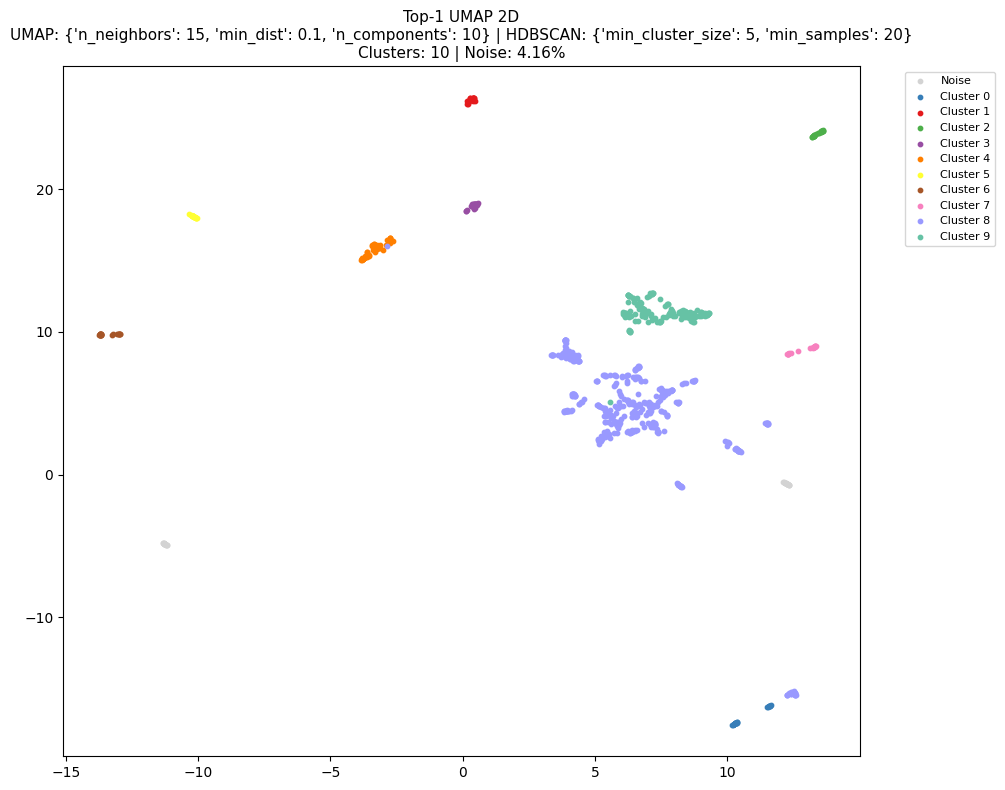

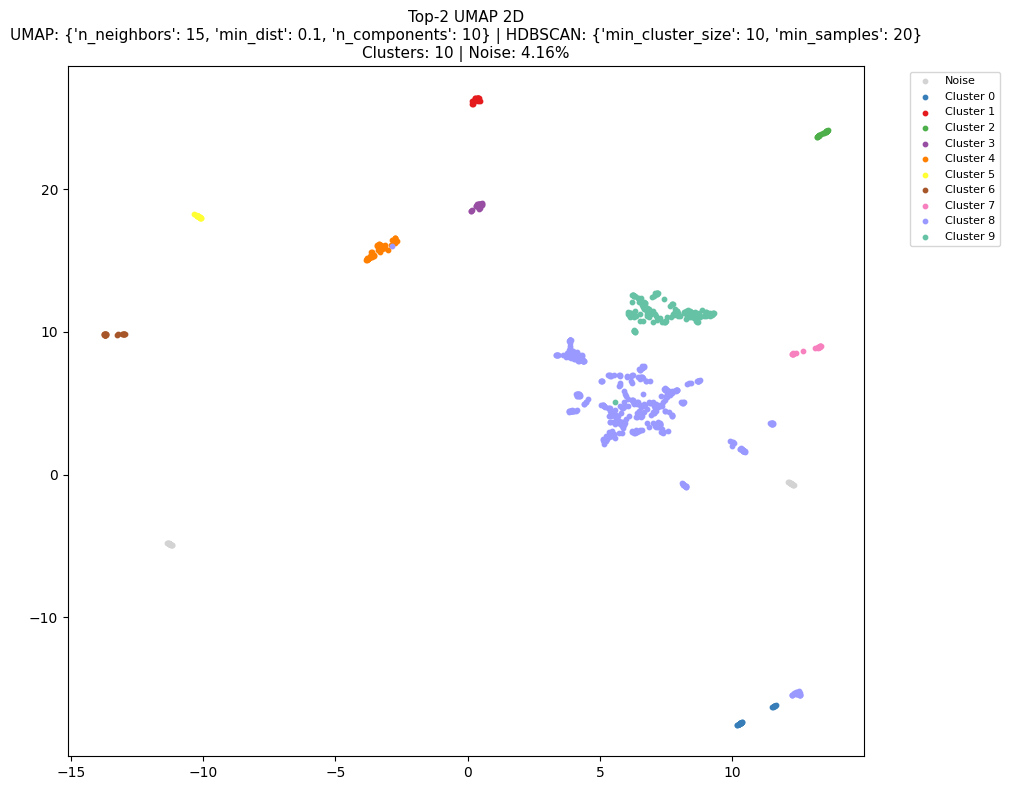

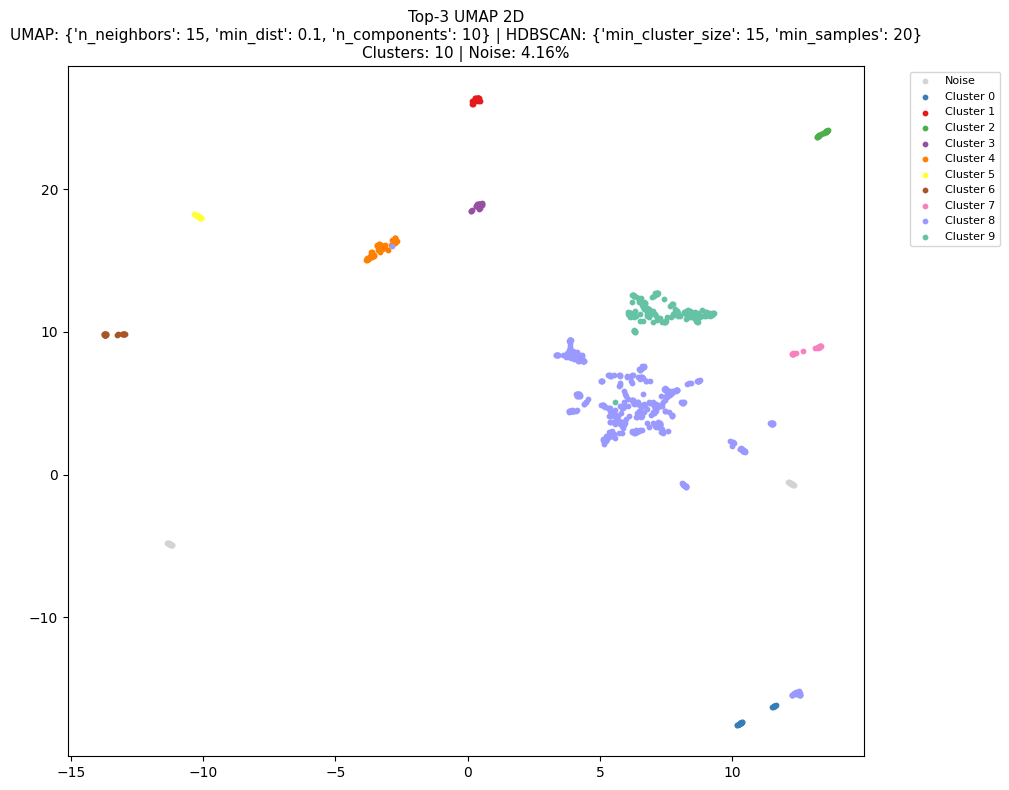

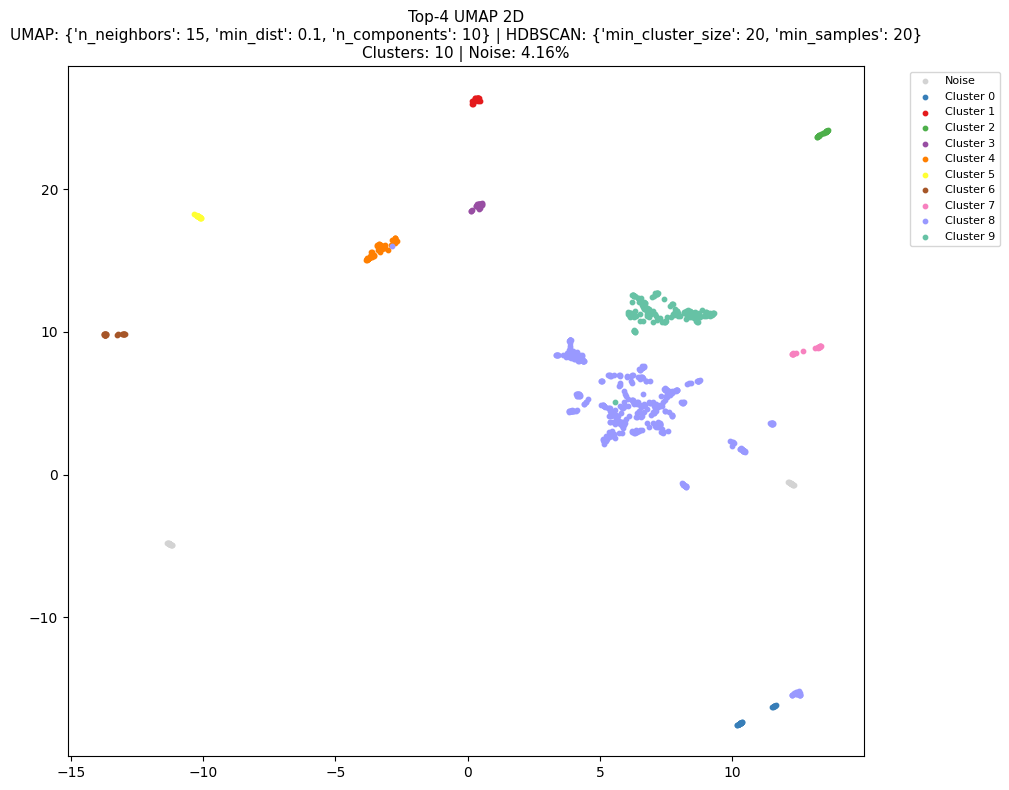

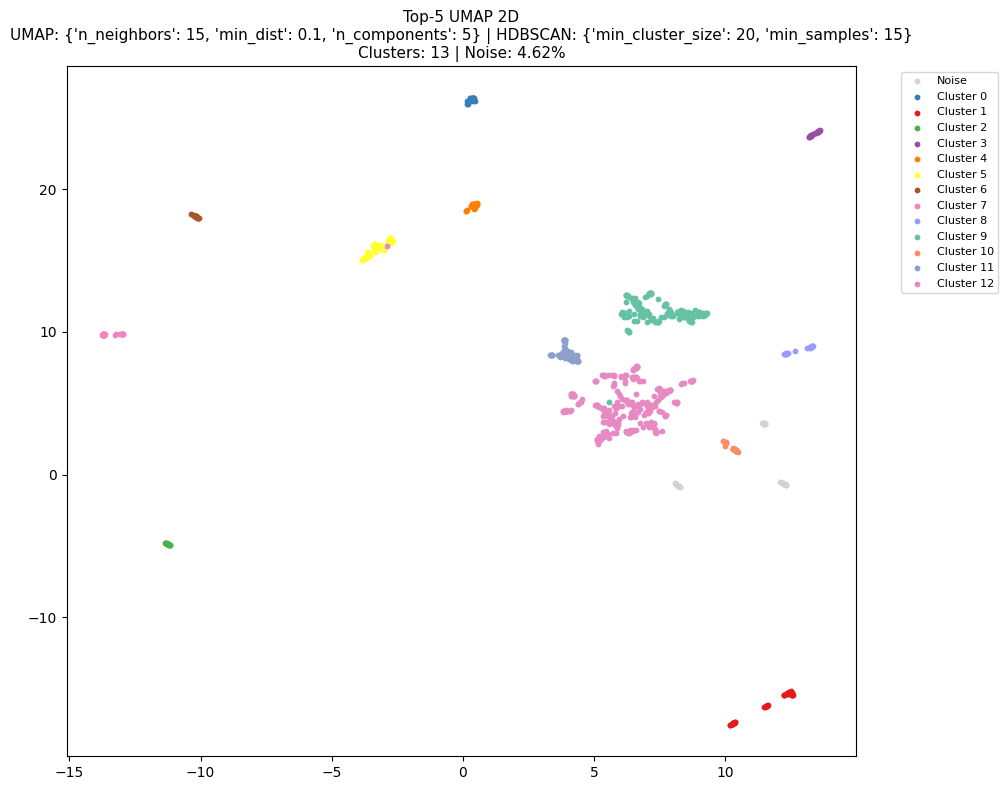

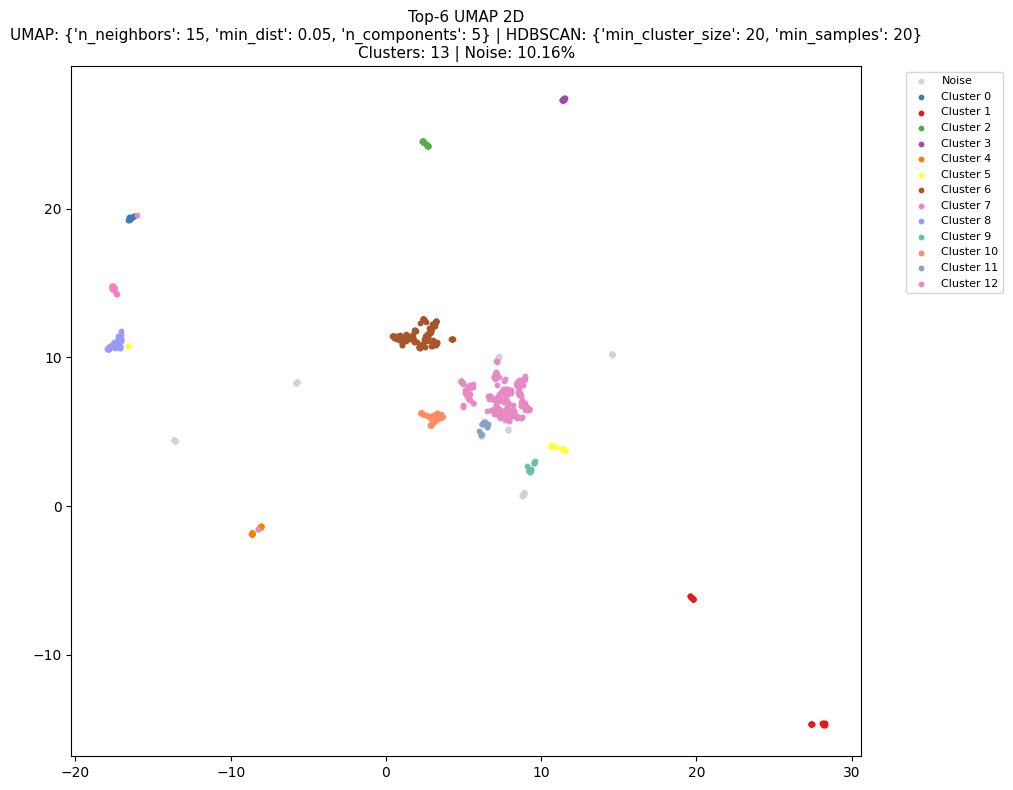

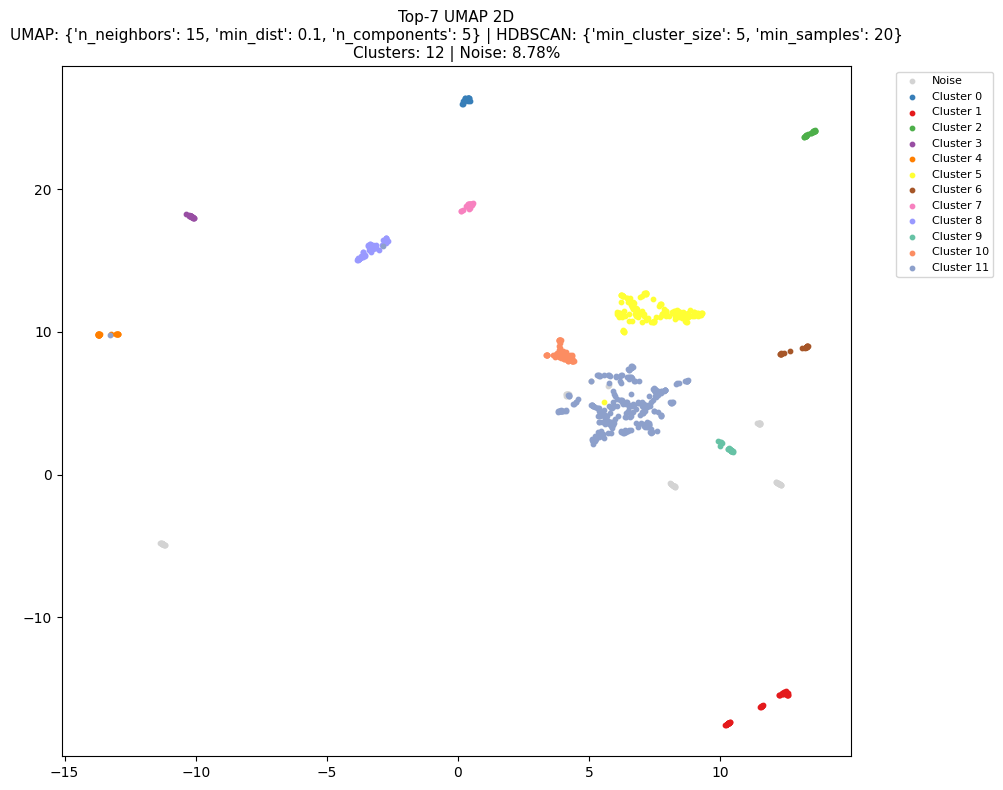

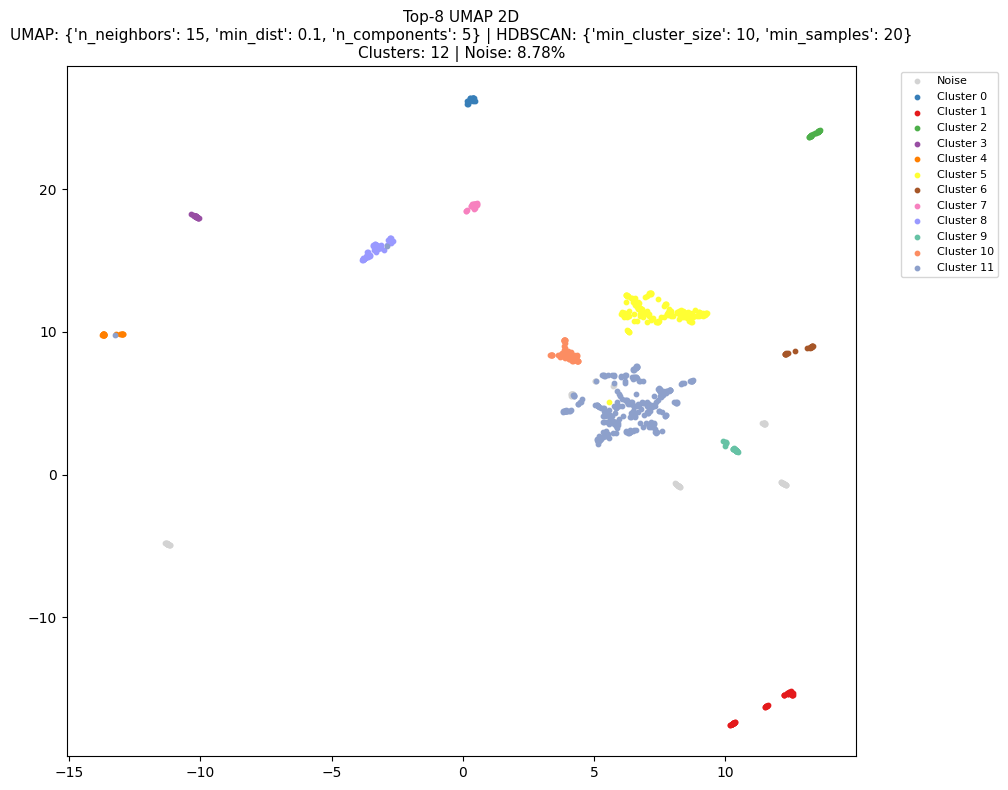

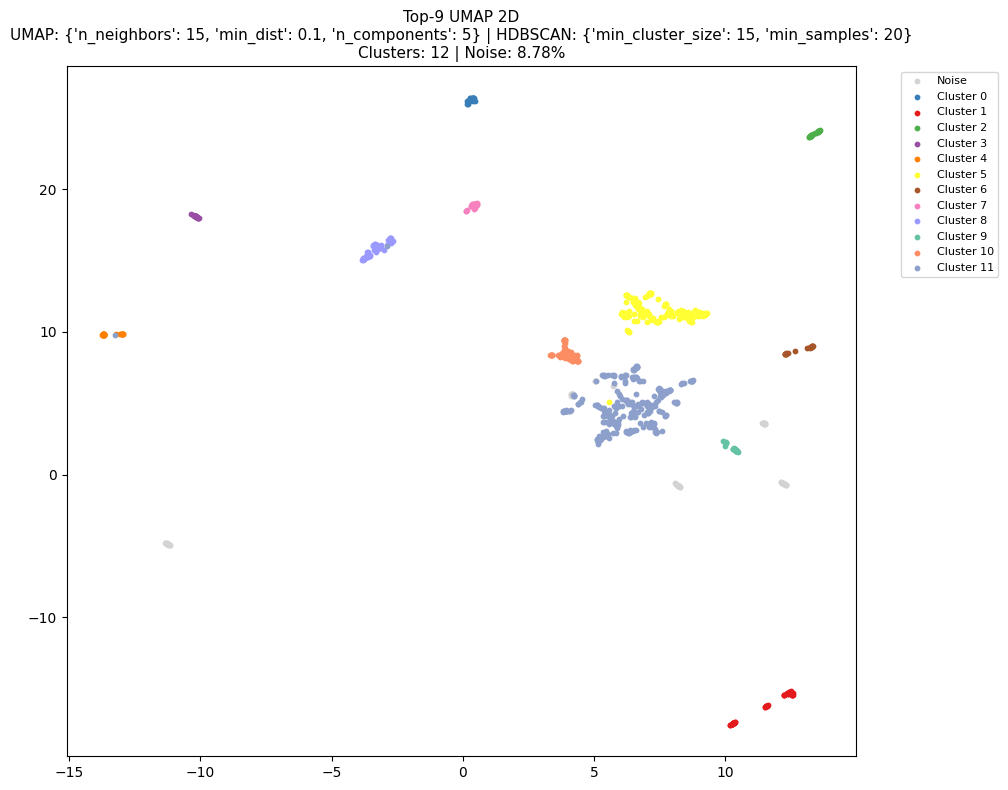

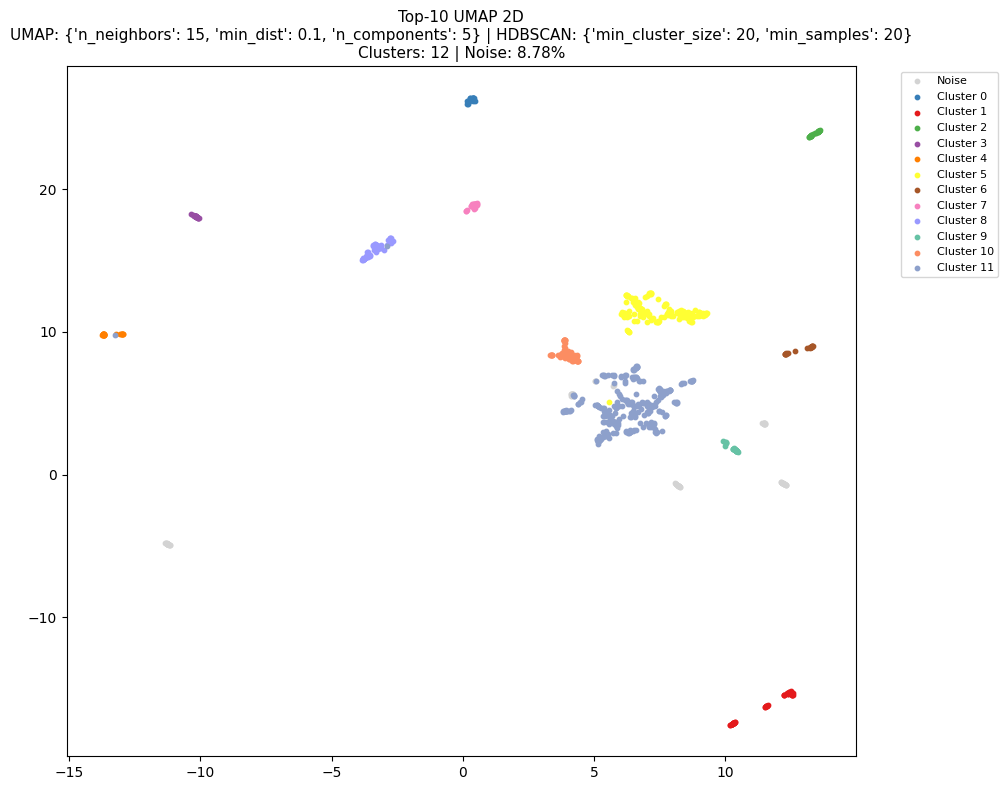

In [ ]:
# 10. DRIVER CODE (Run the whole pipeline)

results = tune_umap_hdbscan(
    X=X,
    texts=fraud_df["full_text"].tolist(),
    umap_grid=umap_param_grid,
    hdb_grid=hdb_param_grid
)

top10 = select_top10(results)

# Export summary CSV
export_results_to_csv(top10)

# Plot all 10 models correctly
for i, r in enumerate(top10):
    cluster_color_map = build_cluster_color_map(r["labels"])

    plot_umap_2d(
        X_2d=r["X_2d"],
        labels=r["labels"],
        umap_params=r["umap"],
        hdb_params=r["hdbscan"],
        num_clusters=r["num_clusters"],
        noise_pct=r["noise_pct"],
        cluster_color_map=cluster_color_map,
        title_prefix=f"Top-{i+1} UMAP 2D"
    )

    plot_umap_3d(
        X_3d=r["X_3d"],
        labels=r["labels"],
        umap_params=r["umap"],
        hdb_params=r["hdbscan"],
        num_clusters=r["num_clusters"],
        noise_pct=r["noise_pct"],
        cluster_color_map=cluster_color_map,
        title_prefix=f"Top-{i+1} UMAP 3D"
    )


The Top-5 hyperparameter configuration was selected because it produced the most stable, interpretable, and semantically coherent clustering structure among all candidates.

In both UMAP-2D and UMAP-3D projections, this configuration yielded clear, compact, and non-overlapping clusters, indicating strong manifold preservation and reliable local density structure. Unlike the UMAP-10D models (Top-1 to Top-4), which over-merged distinct fraud behaviours, and other UMAP-5D configurations (Top-6 to Top-10), which suffered from fragmentation and increased noise, the Top-5 setting consistently revealed well-defined cluster boundaries.

It achieved an optimal balance by producing 13 meaningful clusters—rich enough to capture genuine fraud subtypes without introducing instability. This configuration also maintained an ideal noise level (4.6%), reflecting stable cluster cores and minimal ambiguity. Critically, TF-IDF keyword themes and feature profiles were the most coherent under this configuration. Combined with strong DBCV and persistence scores, the Top-5 hyperparameter set demonstrated the best overall trade-off between dimensionality reduction quality, density-based separability, and semantic interpretability, making it the most defensible choice for downstream fraud subtype analysis.

# Mapping of clusters to job listings for best config

In [ ]:
# Input best params
# To be edited by user after analysing the shortlisted hyperparameter results
best_umap_params = {
    "n_neighbors": 15,
    "min_dist": 0.1,
    "n_components": 5
}

best_hdbscan_params = {
    "min_cluster_size": 20,
    "min_samples": 15
}

In [ ]:
def run_final_clustering(X, umap_params, hdbscan_params):

    # UMAP dimensionality reduction
    reducer = umap.UMAP(
        n_neighbors=umap_params["n_neighbors"],
        min_dist=umap_params["min_dist"],
        n_components=umap_params["n_components"],
        metric="cosine",
        random_state=42
    )
    X_umap = reducer.fit_transform(X)

    # HDBSCAN clustering
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=hdbscan_params["min_cluster_size"],
        min_samples=hdbscan_params["min_samples"],
        cluster_selection_method="eom",
        metric="euclidean"
    )

    labels = clusterer.fit_predict(X_umap)

    return labels, X_umap

In [ ]:
final_labels, final_umap = run_final_clustering(
    X=X,
    umap_params=best_umap_params,
    hdbscan_params=best_hdbscan_params
)

print("Unique clusters:", np.unique(final_labels))
print("Noise %:", np.mean(final_labels == -1))

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Unique clusters: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12]
Noise %: 0.046189376443418015


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



In [ ]:
# 1. Copy df
fraud_df_with_clusters = fraud_df.copy()

# 2. Add cluster labels
fraud_df_with_clusters["cluster"] = final_labels

# 3. Drop embedding columns
emb_cols = [c for c in fraud_df_with_clusters.columns if c.startswith("st_emb_")]
fraud_df_with_clusters = fraud_df_with_clusters.drop(columns=emb_cols)

fraud_df_with_clusters.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,...,requirements_POS_TOTAL_TOKENS_log,benefits_sentence_count_log,benefits_exclamation_count_log,benefits_question_count_log,benefits_all_caps_words_log,benefits_gunning_fog_log,benefits_POS_TOTAL_TOKENS_log,location_segment_count_log,full_text,cluster
0,17128,Customer Service Rep,"US, MO, Grandview",customer service,NaN,NaN,We are seeking a Customer Service Representati...,NaN,NaN,0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.386294,[SEP] We are seeking a Customer Service Repre...,12
1,5751,"Agency Sales Managers $150-$175,000/yr","US, NY, Elmira",NaN,NaN,We have aggressive growth plans in place for t...,We provide No Credit Check Financing to custom...,Experience and Skills Required- Minimum of 3 ...,We Provide- Complete online training and offic...,0,...,3.663562,0.000000,0.0,0.0,0.0,3.265014,3.784190,1.386294,We have aggressive growth plans in place for t...,7
2,5611,Optical Sales,"US, NY, Plainview",NaN,NaN,NaN,Optometric practice is seeking a full-time Opt...,Responsibilities include educating and assisti...,We offer a team-oriented work environment and ...,0,...,3.610918,0.693147,0.0,0.0,0.0,3.182753,3.258097,1.386294,[SEP] Optometric practice is seeking a full-t...,-1
3,17519,Part Time Cash Jobs To Immediate Starts.,"US, CA, Los Angeles",NaN,NaN,NaN,Part Time Cash Jobs To Immediate Starts.No Exp...,NaN,NaN,0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.386294,[SEP] Part Time Cash Jobs To Immediate Starts...,5
4,17712,Network Marketing,"US, HI,",NaN,7200-1380000,NaN,"Are you looking to make anywhere from 600-115,...","An ambition to succeed, A desire to be the bes...","Residual Income, Travel dollars, Car Dollars, ...",0,...,3.555348,0.000000,0.0,0.0,0.0,2.672556,3.295837,1.098612,[SEP] Are you looking to make anywhere from 6...,8


In [ ]:
# Create missing indicator variables
fraud_df_with_clusters["company_profile_missing"] = fraud_df_with_clusters["company_profile"].isna().astype(int)
fraud_df_with_clusters["requirements_missing"] = fraud_df_with_clusters["requirements"].isna().astype(int)
fraud_df_with_clusters["benefits_missing"] = fraud_df_with_clusters["benefits"].isna().astype(int)

In [ ]:
fraud_df_with_clusters.to_csv(
    f"{FILE_PATH}fraud_df_with_clusters.csv",
    index=False
)

print("Saved fraud_df_with_clusters.csv!")

Saved fraud_df_with_clusters.csv!


# Clusters profiling

## Cluster size summary


Cluster Size Summary:
         count  percentage
cluster                   
-1          40        4.62
 0          29        3.35
 1          48        5.54
 2          20        2.31
 3          24        2.77
 4          31        3.58
 5          53        6.12
 6          22        2.54
 7          23        2.66
 8          22        2.54
 9         162       18.71
 10         25        2.89
 11         63        7.27
 12        304       35.10


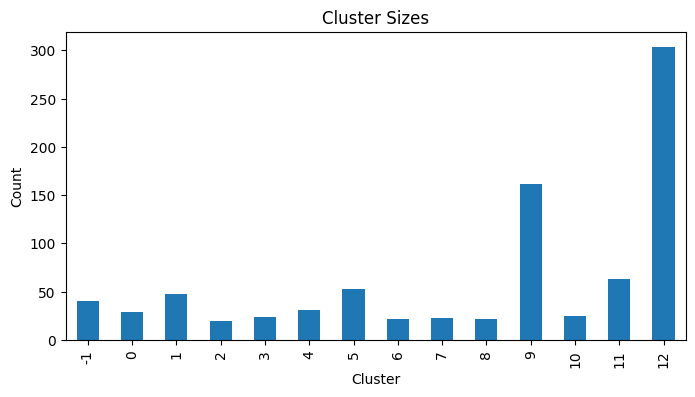

In [ ]:
cluster_sizes = fraud_df_with_clusters["cluster"].value_counts().sort_index()
cluster_pct = (cluster_sizes / cluster_sizes.sum() * 100).round(2)

# Combine both for nicer display
summary_df = pd.DataFrame({
    "count": cluster_sizes,
    "percentage": cluster_pct
})
print("\nCluster Size Summary:")
print(summary_df)


cluster_sizes.plot(kind="bar", figsize=(8,4), title="Cluster Sizes")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.show()

## TF-IDF profiling

In [ ]:
def extract_tfidf_topk(texts, labels, k=10):
    results = {}
    n = len(texts)

    for cid in np.unique(labels):
        if cid == -1:
            continue

        cluster_texts = [texts[i] for i in range(n) if labels[i] == cid]
        results[cid] = {}

        for ngram, key in [((1,1), "unigrams"), ((2,2), "bigrams"), ((3,3), "trigrams")]:
            vec = TfidfVectorizer(ngram_range=ngram, stop_words="english", max_features=5000)
            X = vec.fit_transform(cluster_texts)
            scores = np.asarray(X.sum(axis=0)).ravel()
            vocab = vec.get_feature_names_out()
            top_idx = scores.argsort()[::-1][:k]
            results[cid][key] = vocab[top_idx].tolist()

    return results

tfidf_clusters = extract_tfidf_topk(
    fraud_df_with_clusters["full_text"].tolist(),
    fraud_df_with_clusters["cluster"].tolist(),
    k=10
)

## Numerical and several binary categorical features

In [ ]:
# Numerical -> Z-score proflimg
length_features = [
    "title_char_count","title_word_count","title_sentence_count",
    "title_avg_word_length","title_avg_sentence_length",

    "department_char_count","department_word_count","department_sentence_count",
    "department_avg_word_length","department_avg_sentence_length",

    "company_profile_char_count","company_profile_word_count","company_profile_sentence_count",
    "company_profile_avg_word_length","company_profile_avg_sentence_length",

    "description_char_count","description_word_count","description_sentence_count",
    "description_avg_word_length","description_avg_sentence_length",

    "requirements_char_count","requirements_word_count","requirements_sentence_count",
    "requirements_avg_word_length","requirements_avg_sentence_length",

    "benefits_char_count","benefits_word_count","benefits_sentence_count",
    "benefits_avg_word_length","benefits_avg_sentence_length",
]


# Numerical -> Z-score profiling
readability_features = [
    "company_profile_flesch_score","company_profile_gunning_fog",
    "company_profile_spelling_error_rate","company_profile_objective_score",

    "description_flesch_score","description_gunning_fog",
    "description_spelling_error_rate","description_objective_score",

    "requirements_flesch_score","requirements_gunning_fog",
    "requirements_spelling_error_rate","requirements_objective_score",

    "benefits_flesch_score","benefits_gunning_fog",
    "benefits_spelling_error_rate","benefits_objective_score",
]


# Numerical -> Z-score profiling
spam_noise_features = [
    # Character patterns
    "title_digit_ratio","title_special_char_ratio","title_longest_repeated_chars_length",
    "department_digit_ratio","department_special_char_ratio","department_longest_repeated_chars_length",
    "company_profile_digit_ratio","company_profile_special_char_ratio","company_profile_longest_repeated_chars_length",
    "description_digit_ratio","description_special_char_ratio","description_longest_repeated_chars_length",
    "requirements_digit_ratio","requirements_special_char_ratio","requirements_longest_repeated_chars_length",
    "benefits_digit_ratio","benefits_special_char_ratio","benefits_longest_repeated_chars_length",

    "title_unique_word_normalised","title_unique_char_normalised",
    "department_unique_word_normalised","department_unique_char_normalised",
    "company_profile_unique_word_normalised","company_profile_unique_char_normalised",
    "description_unique_word_normalised","description_unique_char_normalised",
    "requirements_unique_word_normalised","requirements_unique_char_normalised",
    "benefits_unique_word_normalised","benefits_unique_char_normalised",

    # Punctuation emphasis
    "company_profile_exclamation_count","company_profile_exclamation_normalised",
    "company_profile_question_count","company_profile_question_normalised",
    "company_profile_all_caps_words","company_profile_all_caps_words_normalised",
    "company_profile_uppercase_ratio",

    "description_exclamation_count","description_exclamation_normalised",
    "description_question_count","description_question_normalised",
    "description_all_caps_words","description_all_caps_words_normalised",
    "description_uppercase_ratio",

    "requirements_exclamation_count","requirements_exclamation_normalised",
    "requirements_question_count","requirements_question_normalised",
    "requirements_all_caps_words","requirements_all_caps_words_normalised",
    "requirements_uppercase_ratio",

    "benefits_exclamation_count","benefits_exclamation_normalised",
    "benefits_question_count","benefits_question_normalised",
    "benefits_all_caps_words","benefits_all_caps_words_normalised",
    "benefits_uppercase_ratio",
]


# Numerical -> Z-score profiling
sentiment_features = [
    "company_profile_sentiment_pos","company_profile_sentiment_neg","company_profile_sentiment_compound",
    "description_sentiment_pos","description_sentiment_neg","description_sentiment_compound",
    "requirements_sentiment_pos","requirements_sentiment_neg","requirements_sentiment_compound",
    "benefits_sentiment_pos","benefits_sentiment_neg","benefits_sentiment_compound",
]


# Numerical -> Z-score profiling
pos_features = [
    "company_profile_POS_NOUN_normalised","company_profile_POS_VERB_normalised",
    "company_profile_POS_ADJ_normalised","company_profile_POS_NUM_normalised",
    "company_profile_POS_DET_normalised","company_profile_POS_ADP_normalised",
    "company_profile_POS_CONJ_normalised","company_profile_POS_PRON_normalised",
    "company_profile_POS_PRT_normalised","company_profile_POS_ADV_normalised",
    "company_profile_POS_X_normalised","company_profile_POS_TOTAL_TOKENS",

    "description_POS_NOUN_normalised","description_POS_VERB_normalised",
    "description_POS_ADJ_normalised","description_POS_NUM_normalised",
    "description_POS_DET_normalised","description_POS_ADP_normalised",
    "description_POS_CONJ_normalised","description_POS_PRON_normalised",
    "description_POS_PRT_normalised","description_POS_ADV_normalised",
    "description_POS_X_normalised","description_POS_TOTAL_TOKENS",

    "requirements_POS_NOUN_normalised","requirements_POS_VERB_normalised",
    "requirements_POS_ADJ_normalised","requirements_POS_NUM_normalised",
    "requirements_POS_DET_normalised","requirements_POS_ADP_normalised",
    "requirements_POS_CONJ_normalised","requirements_POS_PRON_normalised",
    "requirements_POS_PRT_normalised","requirements_POS_ADV_normalised",
    "requirements_POS_X_normalised","requirements_POS_TOTAL_TOKENS",

    "benefits_POS_NOUN_normalised","benefits_POS_VERB_normalised",
    "benefits_POS_ADJ_normalised","benefits_POS_NUM_normalised",
    "benefits_POS_DET_normalised","benefits_POS_ADP_normalised",
    "benefits_POS_CONJ_normalised","benefits_POS_PRON_normalised",
    "benefits_POS_PRT_normalised","benefits_POS_ADV_normalised",
    "benefits_POS_X_normalised","benefits_POS_TOTAL_TOKENS",
]


# Binary categorical features -> Can still use Z-score profiling
# since the mean represents the proportion (e.g. mean of has_url = 0.7 -> 70% of postings contain URL)
contact_features = [
    "company_profile_has_url","company_profile_has_email","company_profile_has_phone",
    "description_has_url","description_has_email","description_has_phone",
    "requirements_has_url","requirements_has_email","requirements_has_phone",
    "benefits_has_url","benefits_has_email","benefits_has_phone",
]


# Binary categorical features -> Can still use Z-score profiling
missing_duplicated_features = [
    "company_profile_missing",
    "requirements_missing",
    "benefits_missing",

    "company_profile_duplicated",
    "description_duplicated",
    "requirements_duplicated",
    "benefits_duplicated",
]


# Binary categorical features -> Can use Z-score profiling
remote_indication_features = [
    "remote_text_flag","mismatch_remote",
    "title_contains_remote_keywords","description_contains_remote_keywords",
    "company_profile_contains_remote_keywords","requirements_contains_remote_keywords",
    "benefits_contains_remote_keywords", "telecommuting"
]


feature_groups = {
    "Length & Structure": length_features,
    "Readability": readability_features,
    "Spam & Text Noise": spam_noise_features,
    "Sentiment": sentiment_features,
    "POS": pos_features,
    "Contact": contact_features,
    "Missing & Duplicated Structure": missing_duplicated_features,
    "Remote indication": remote_indication_features,
}


In [ ]:
def compute_z_scores(df, feature_list, cluster_col="cluster"):
    global_mean = df[feature_list].mean()
    global_std = df[feature_list].std()

    results = {}

    for cluster_id in sorted(df[cluster_col].unique()):
        if cluster_id == -1:   # skip noise
            continue

        subset = df[df[cluster_col] == cluster_id]
        cluster_mean = subset[feature_list].mean()

        z = (cluster_mean - global_mean) / global_std
        z = z.replace([np.inf, -np.inf], np.nan).dropna()
        z = z.sort_values(ascending=False)

        results[cluster_id] = z

    return results

In [ ]:
group_zscores = {}

for group_name, feat_list in feature_groups.items():

    # compute_z_scores returns:  dict(feature -> pd.Series(cluster → zscore))
    z_dict = compute_z_scores(fraud_df_with_clusters, feat_list)

    # Convert dict of Series into DataFrame
    # Each key becomes a column; index = cluster labels
    z_df = pd.DataFrame(z_dict)

    group_zscores[group_name] = z_df

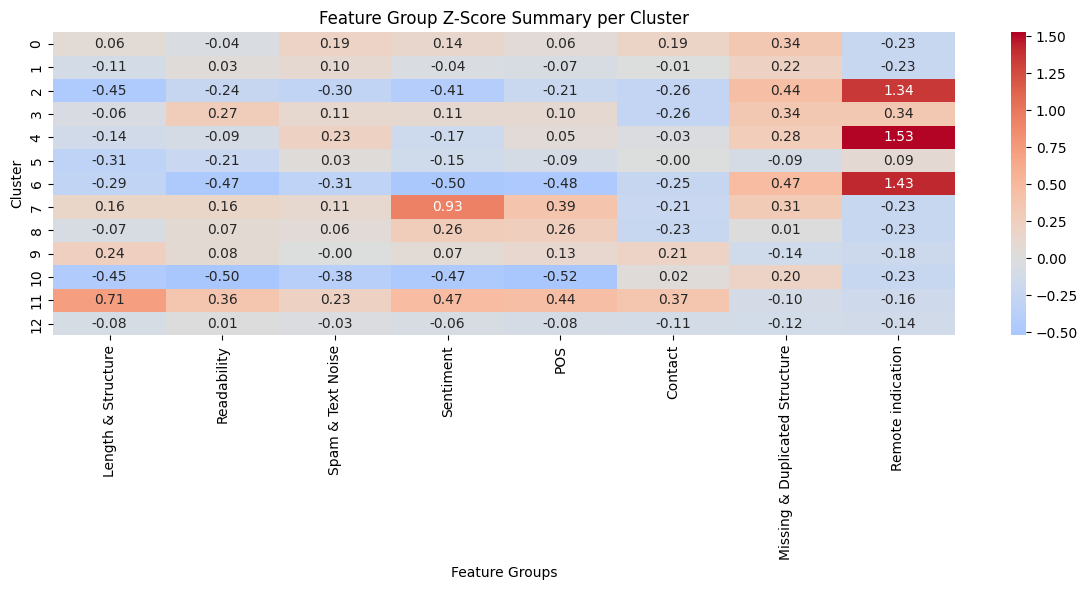

In [ ]:
# Heatmap of mean Z-score per feature group per cluster.
def plot_feature_group_heatmap(group_zscores):

    heatmap_df = {}

    for group_name, z_df in group_zscores.items():
        # z_df: rows = features, columns = clusters
        # mean across rows → one value per cluster
        group_mean = z_df.mean(axis=0)
        heatmap_df[group_name] = group_mean

    heatmap_df = pd.DataFrame(heatmap_df)

    plt.figure(figsize=(12, 6))
    sns.heatmap(
        heatmap_df,
        cmap="coolwarm",
        center=0,
        annot=True,
        fmt=".2f"
    )
    plt.title("Feature Group Z-Score Summary per Cluster")
    plt.xlabel("Feature Groups")
    plt.ylabel("Cluster")
    plt.tight_layout()
    plt.show()

plot_feature_group_heatmap(group_zscores)

# Interpretation:
# red: cluster scores higher than typical fraud postings
# below: cluster scores lower than typical fraud postings
# white: about average

## Categorical Features

In [ ]:
cat_features_for_profiling = [
    "has_company_logo",
    "has_questions",
    "invalid_state",
    "US_listing_without_state_info",
    "is_multi_location_in_city",
    "salary_range_is_date_like",
    "title_contains_action_word",
    "department_invalid_dept",

    "employment_type",
    "required_experience",
    "required_education",
    "industry",
    "function",
    "country",
]

In [ ]:
def categorical_profile(df, categorical_features, cluster_col="cluster"):
    results = {}

    for cluster_id in sorted(df[cluster_col].unique()):
        if cluster_id == -1:
            continue

        subset = df[df[cluster_col] == cluster_id]

        results[cluster_id] = {
            col: subset[col].value_counts(normalize=True)
            for col in categorical_features
        }

    return results

In [ ]:
categorical_profiles = categorical_profile(
    fraud_df_with_clusters, cat_features_for_profiling
)

## Print persona summary for a cluster

Understand the top distinguishing features per cluster

In [ ]:
def print_cluster_persona(df, cluster_id):
    print("\n" + "="*100)
    print(f" CLUSTER {cluster_id} — PERSONA SUMMARY")
    print("="*100)

    # Example Titles
    print("\nExample Job Titles:")
    print(df[df.cluster==cluster_id]["title"].head(5).tolist())

    # TF-IDF Keywords
    print("\nTop Keywords:")
    print("Unigrams :", tfidf_clusters[cluster_id]["unigrams"])
    print("Bigrams  :", tfidf_clusters[cluster_id]["bigrams"])
    print("Trigrams :", tfidf_clusters[cluster_id]["trigrams"])

    # Z-score standout features
    print("\nStandout (Z-score) Features:")
    for group_name, group_scores in group_zscores.items():
        print(f"\n[{group_name}]")
        print(group_scores[cluster_id].head(10))

    # Categorical distributions
    print("\nCategorical Feature Distribution:")
    for col, dist in categorical_profiles[cluster_id].items():
        top_vals = dist.head(3)
        print(f"\n{col}:")
        print(top_vals)

In [ ]:
for cid in sorted(fraud_df_with_clusters.cluster.unique()):
    if cid != -1:
        print_cluster_persona(fraud_df_with_clusters, cid)



 CLUSTER 0 — PERSONA SUMMARY

Example Job Titles:
['Home Based Payroll Typist/Data Entry Clerks Positions Available', 'Home Based Payroll Typist/Data Entry Clerks Positions Available', 'Customer Service Representative to Enroll People in NO COST Cell Phone Program', 'Home Based Payroll Typist/Data Entry Clerks Positions Available', 'Home Based Payroll Typist/Data Entry Clerks Positions Available']

Top Keywords:
Unigrams : ['entry', 'typing', 'sep', 'skills', 'training', '00', 'start', 'data', 'comfort', 'home']
Bigrams  : ['data entry', 'home typing', 'training need', '00 2500', 'typing doing', 'access internet', '________________________________________don let', '2500 00', 'desirable sep', 'earn comfort']
Trigrams : ['00 2500 00', '00 week seeking', '________________________________________don let opportunity', 'access experience needed', 'access internet participate', 'available area earning', 'area earning 1000', 'applicants 18 years', 'desirable sep basic', 'typing doing data']

